In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import utils


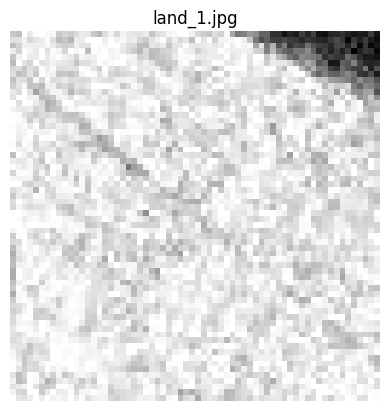

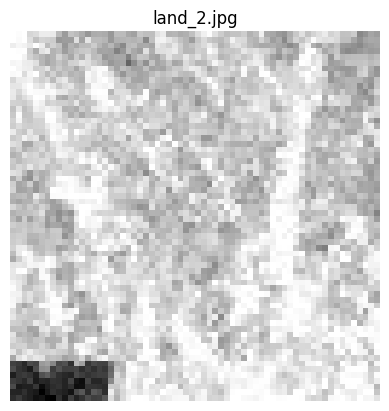

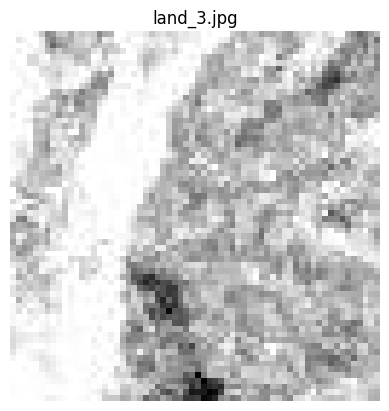

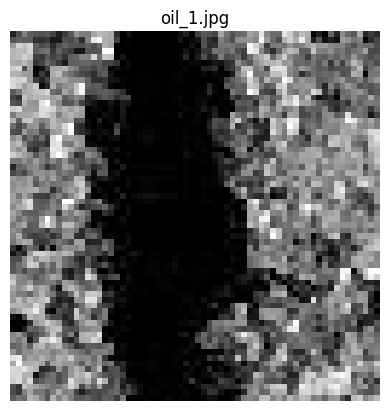

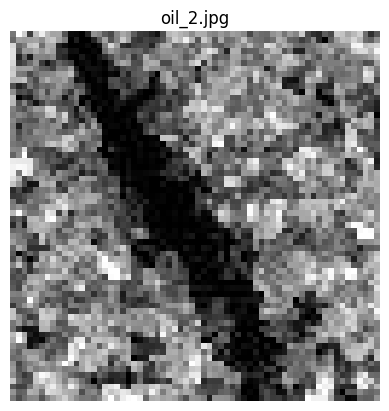

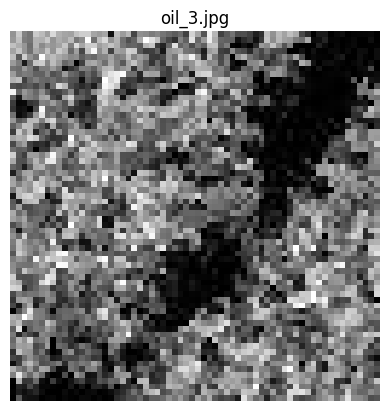

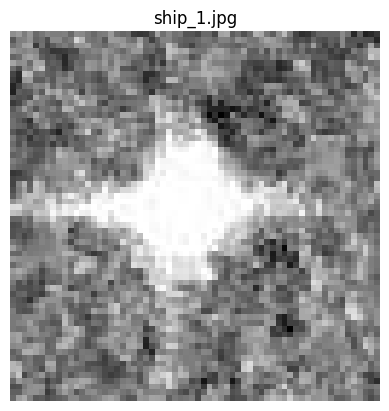

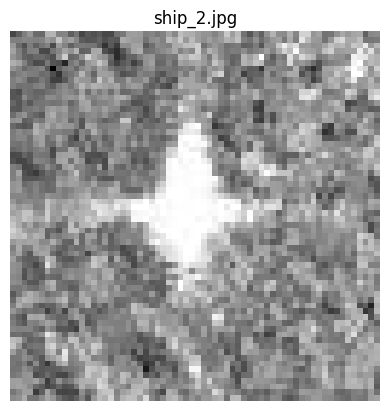

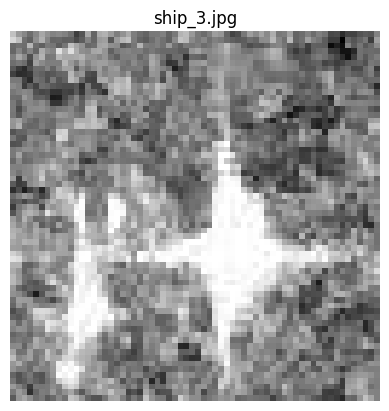

Index(['land_1.jpg', 'land_2.jpg', 'land_3.jpg', 'oil_1.jpg', 'oil_2.jpg',
       'oil_3.jpg', 'ship_1.jpg', 'ship_2.jpg', 'ship_3.jpg'],
      dtype='object')


In [77]:
import data_loading
import os

crop_size = 64
imgs = []

for dirpath, _, filenames in os.walk("data"):
    for fname in sorted(filenames):
        img = data_loading.load_grayscale_image_with_crop(
            path=os.path.join(dirpath, fname),
            crop_size=crop_size,
        )

        imgs.append(img)
        plt.figure()
        plt.imshow(img, cmap="gray")
        plt.title(fname)
        plt.axis("off")
        plt.show()
        
df = data_loading.hilbert_dataframe_from_folder("data", crop_size=crop_size)

labels = df.columns

print(df.columns)


## Check if hilbert curve is ok

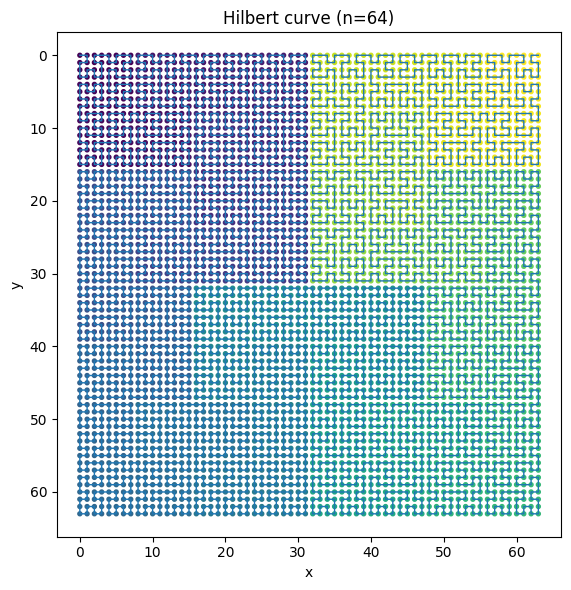

In [78]:
import numpy as np

def hilbert_path(n: int) -> np.ndarray:
    """
    Return Hilbert curve path as an array of shape (n*n, 2)
    with (x, y) coordinates.
    """
    assert (n & (n - 1)) == 0, "n must be power of 2"

    path = np.zeros((n * n, 2), dtype=int)
    for t in range(n * n):
        x, y = utils.hilbert_index_to_xy(t, n)
        path[t] = (x, y)

    return path

import matplotlib.pyplot as plt

def plot_hilbert_curve(n: int):
    path = hilbert_path(n)

    plt.figure(figsize=(6, 6))
    plt.plot(path[:, 0], path[:, 1], lw=1)
    plt.scatter(
        path[:, 0],
        path[:, 1],
        c=np.arange(n * n),
        cmap="viridis",
        s=8
    )

    plt.gca().invert_yaxis()  # match image coordinates
    plt.gca().set_aspect("equal")
    plt.title(f"Hilbert curve (n={n})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    # plt.savefig('hilbert_curve.jpg', dpi=300, bbox_inches="tight")  
    plt.show()

plot_hilbert_curve(64)


# Ordinal patterns para m = 3, 4, 5 y tau = 1, 2

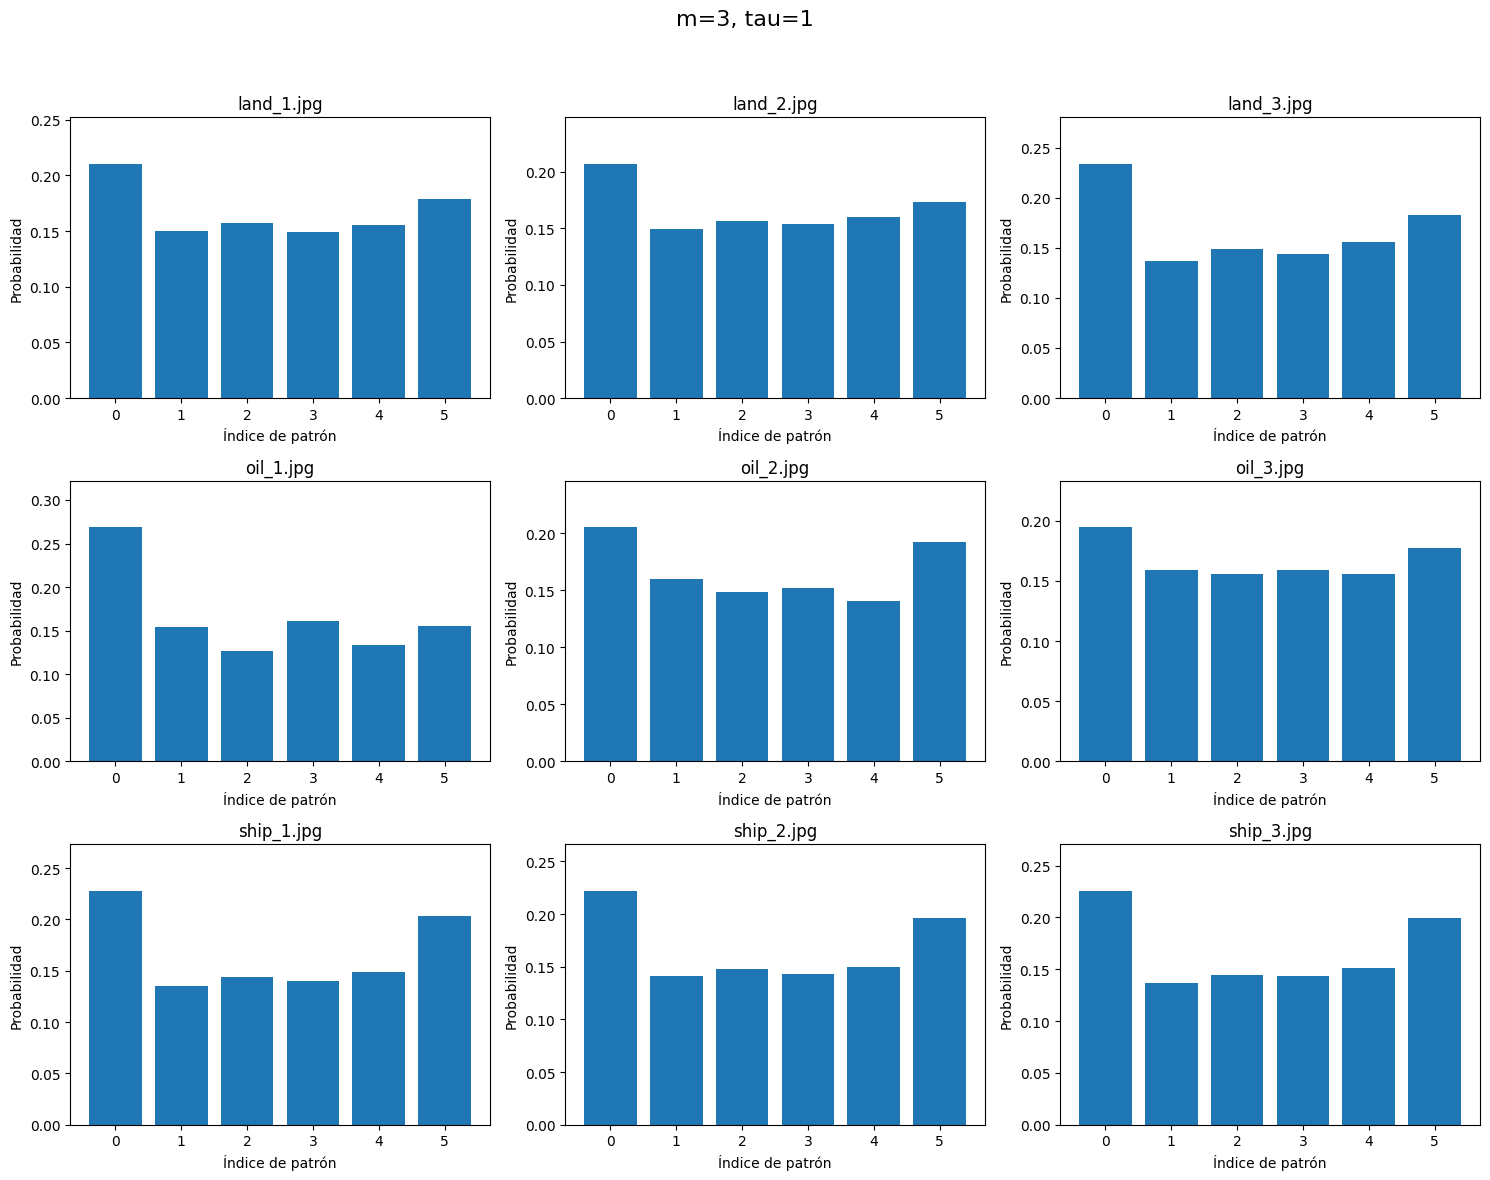

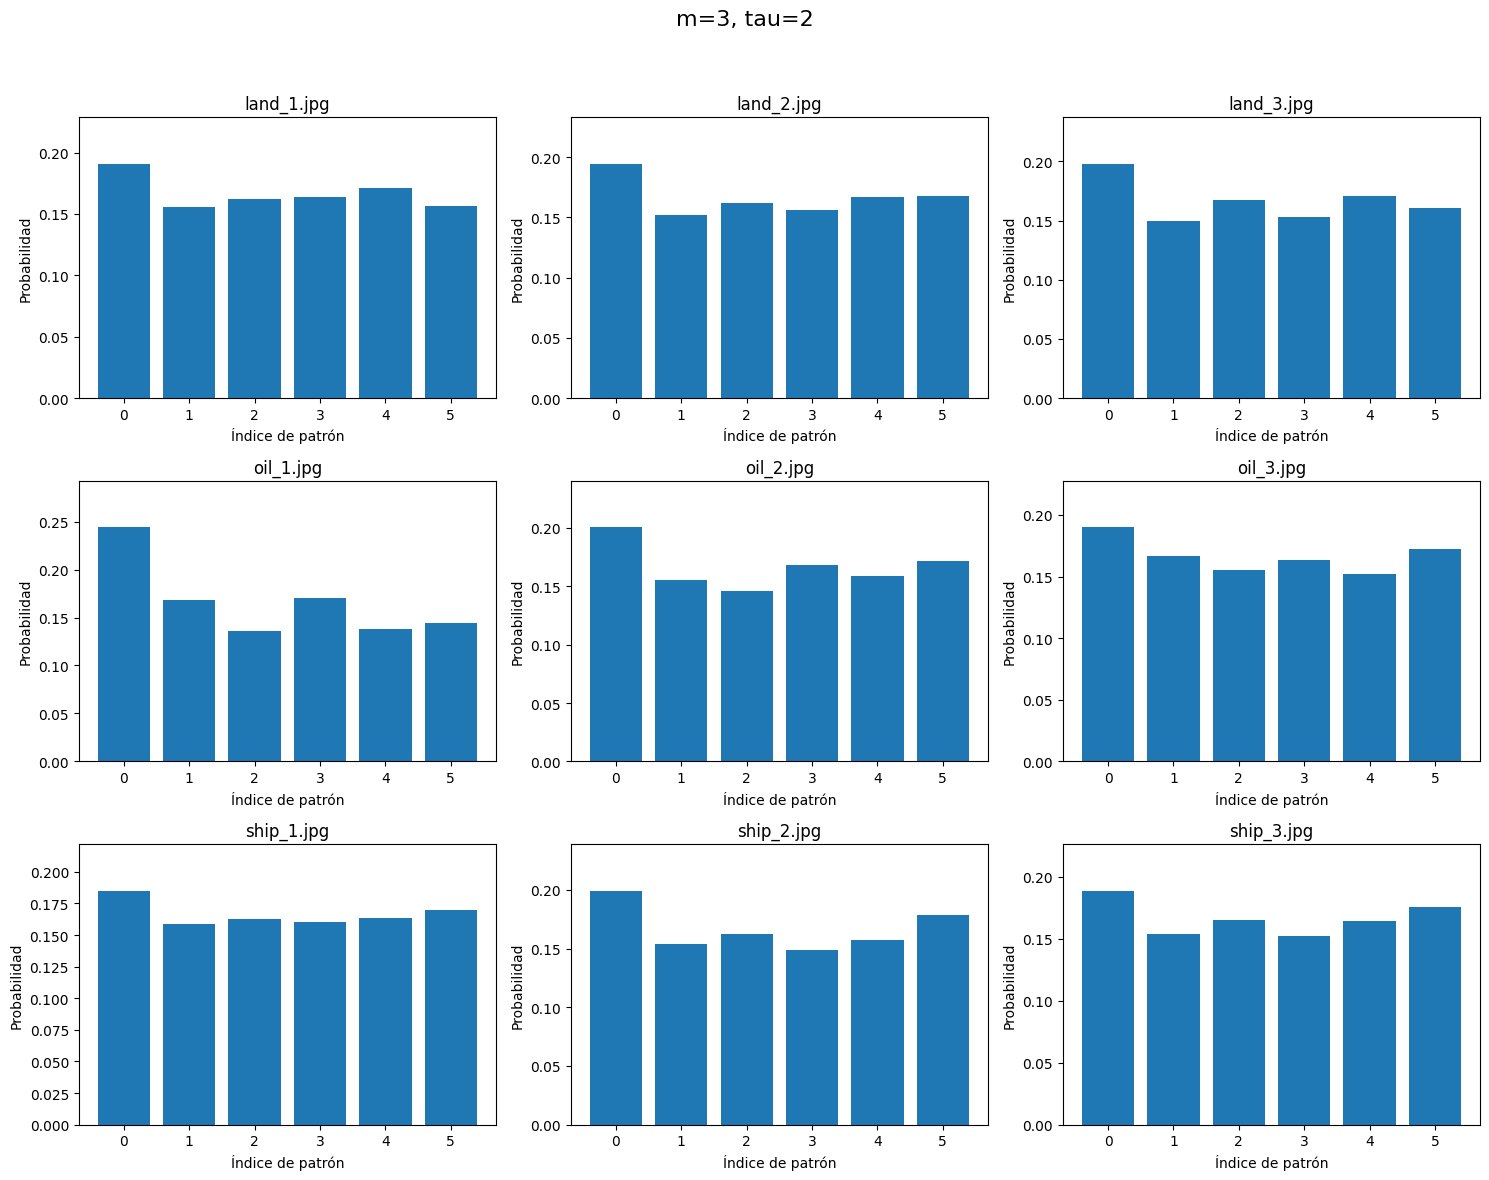

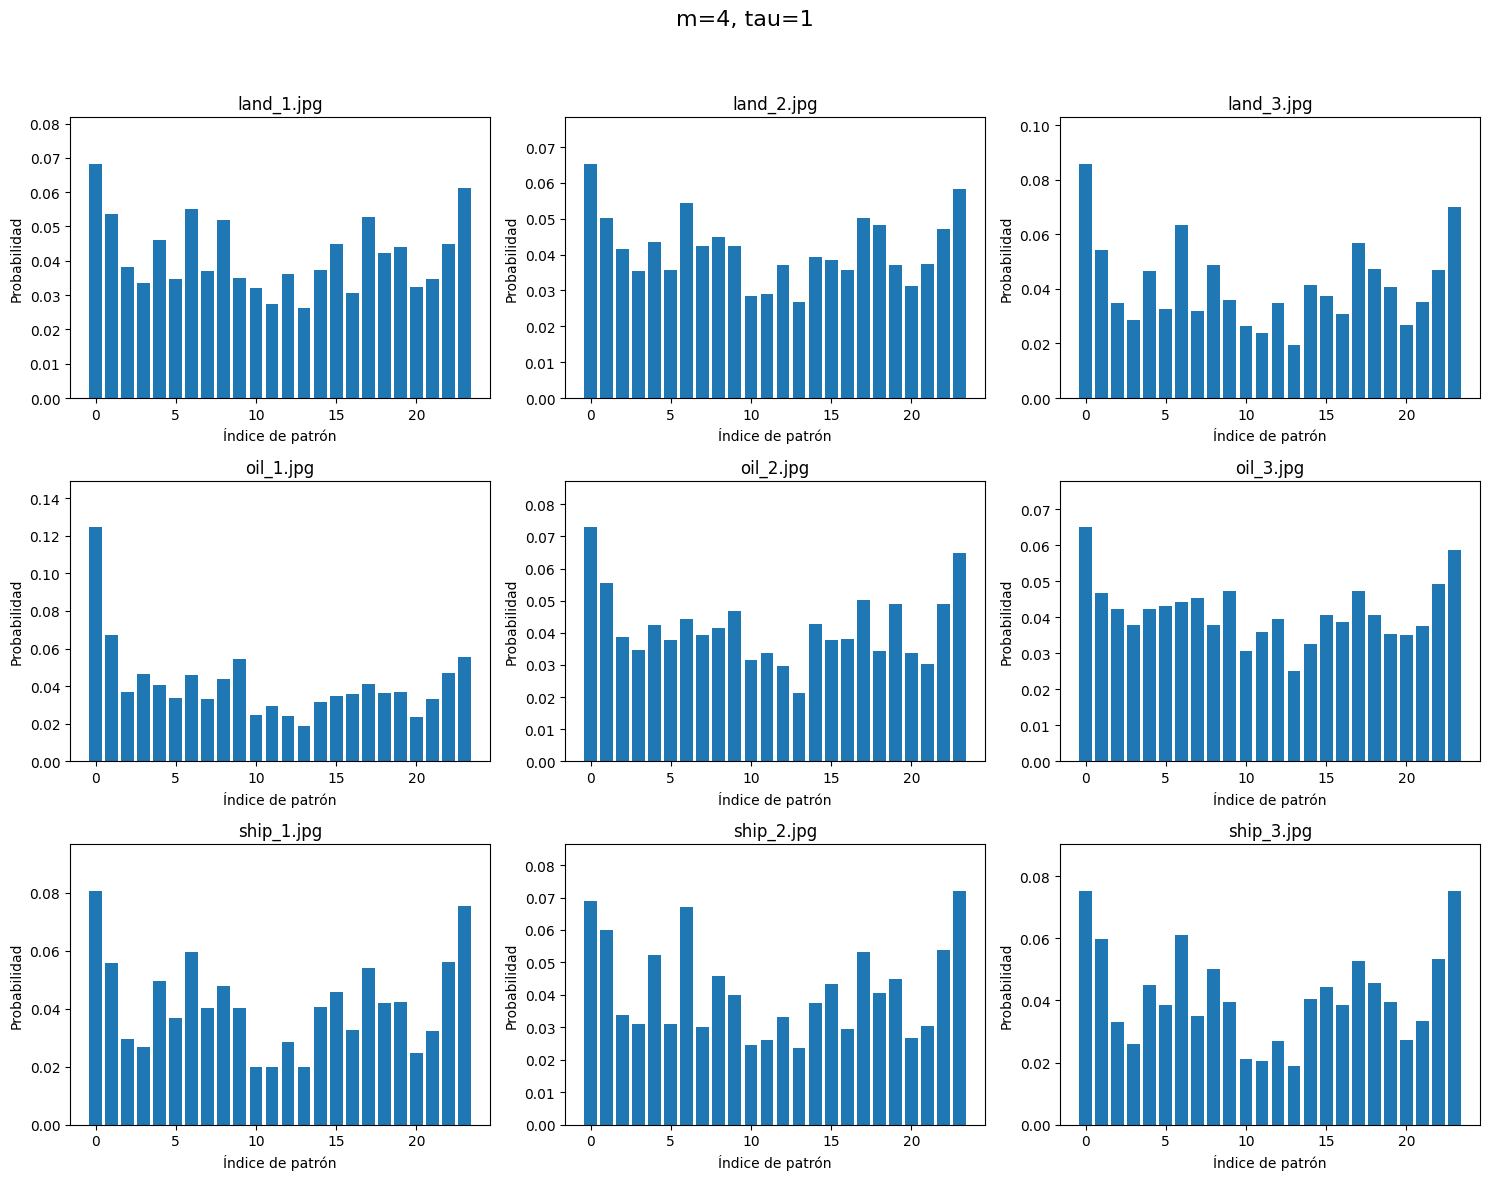

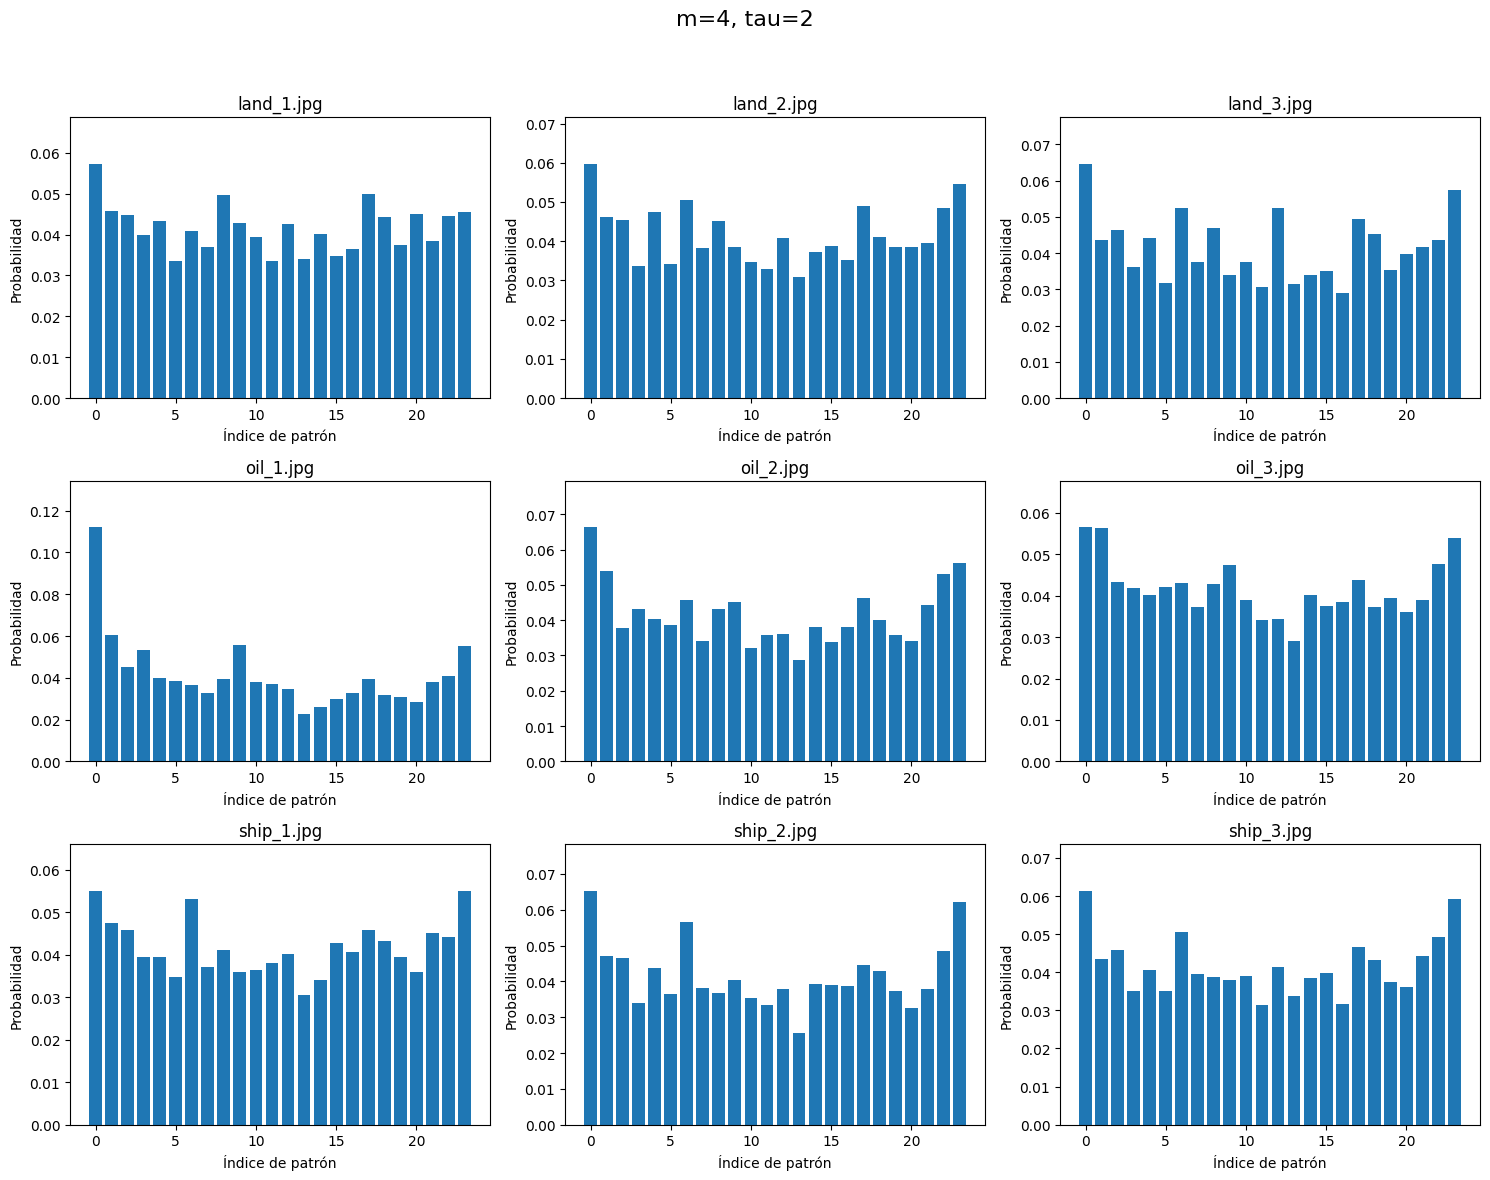

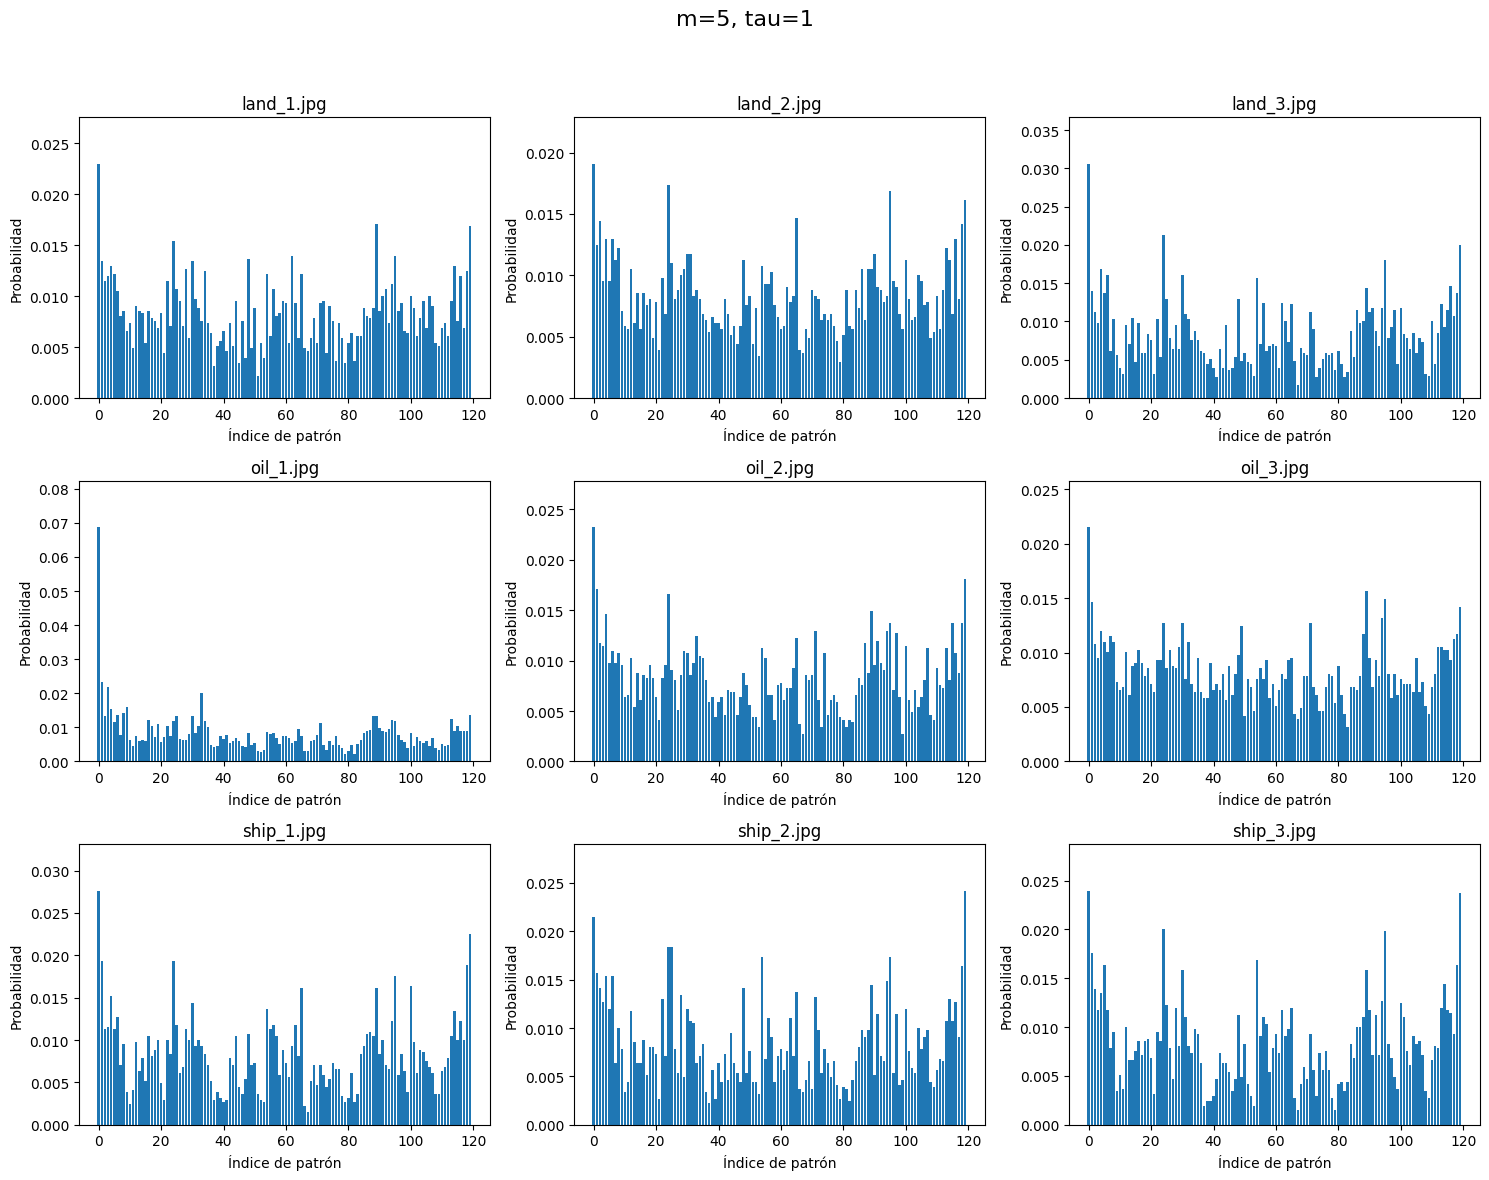

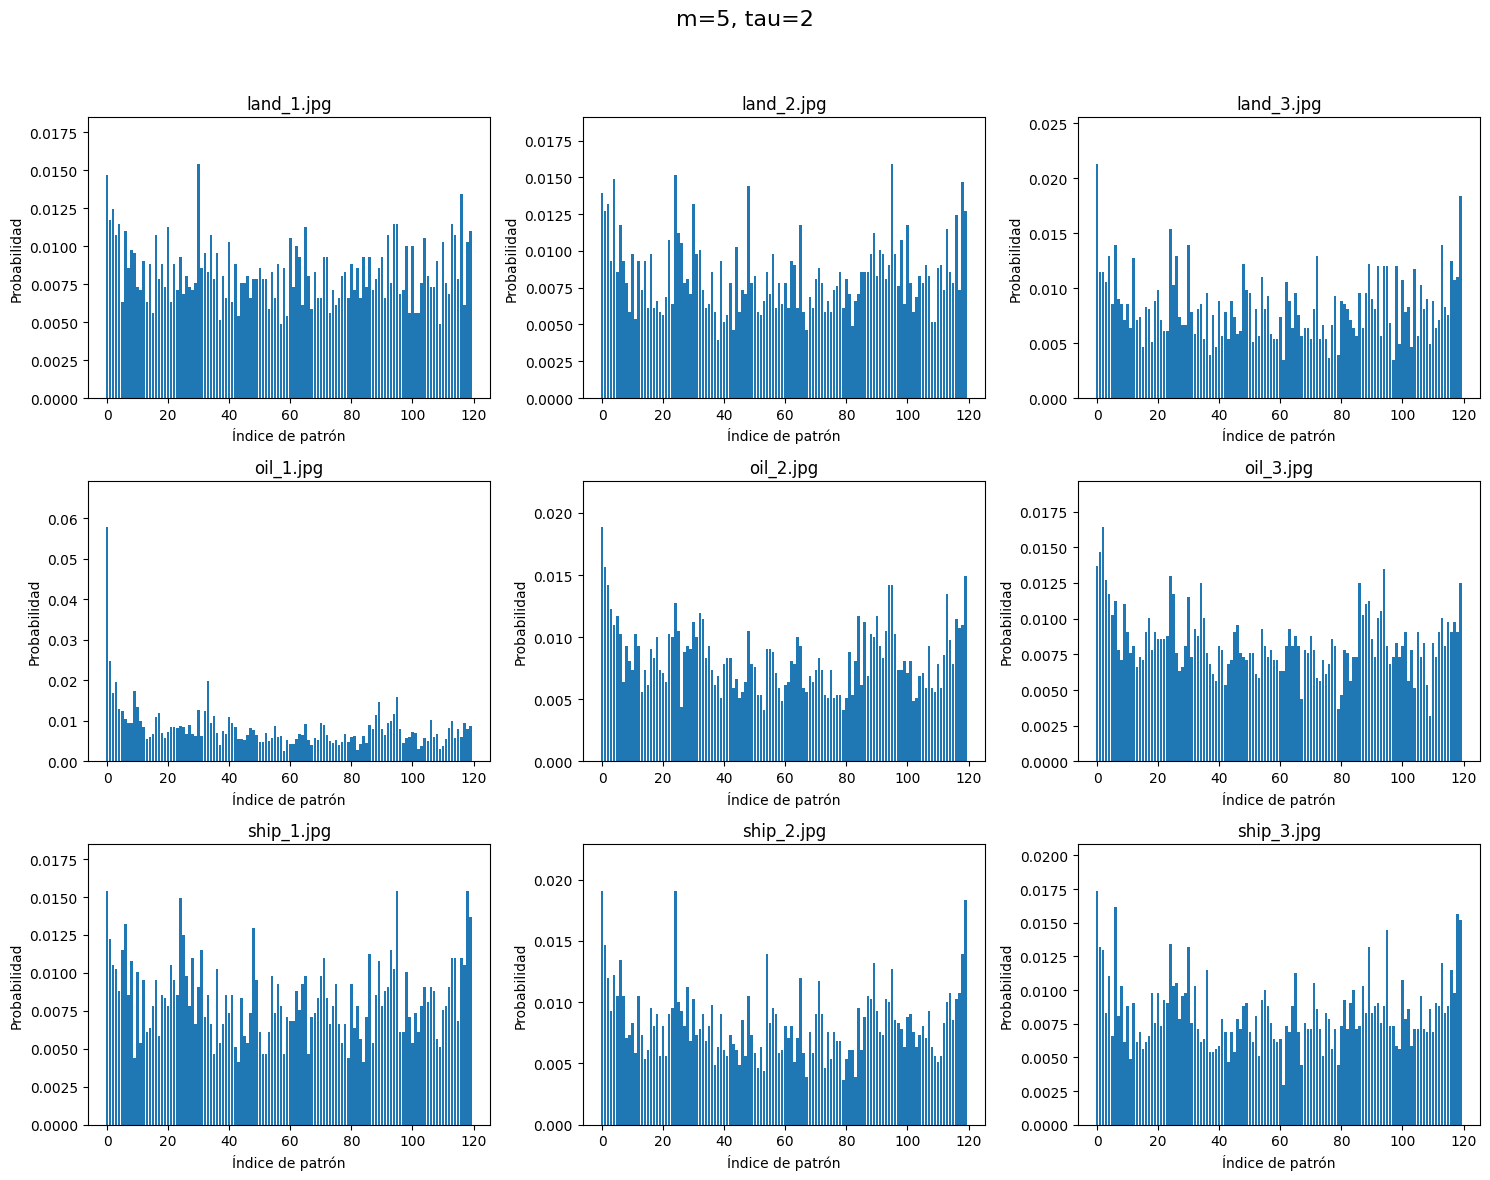

In [79]:
# Parámetros de embedding

m_values = [3, 4, 5]
tau_values = [1, 2]

for m, tau in product(m_values, tau_values):

    cols = df.columns
    ncols = 3
    nrows = int(np.ceil(len(cols) / ncols))

    fig = plt.figure(figsize=(15, 4 * nrows))
    fig.suptitle(f"m={m}, tau={tau}", fontsize=16)

    for i, col in enumerate(cols, 1):
        x = df[col].values

        try:
            _, counts = utils.ordinal_patterns(x, emb_dim=m, emb_lag=tau)
            prob = counts / counts.sum()
        except ValueError:
            continue

        ax = plt.subplot(nrows, ncols, i)
        ax.bar(np.arange(len(prob)), prob)
        ax.set_title(col)
        ax.set_xlabel("Índice de patrón")
        ax.set_ylabel("Probabilidad")
        ax.set_ylim(0, prob.max() * 1.2)

    # CLAVE: ajustar layout ANTES de guardar
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.savefig(
        f"latex/figures/patrones_ordinales/patrones_ordinales_m={m}_tau={tau}.jpg",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()


# Calculo entropias normalizadas

In [80]:
import divergence_entropy
import importlib
importlib.reload(divergence_entropy)
import pandas as pd

def entropy_complexity_full(dfs, m_values, tau_values, alpha=2.0, q=2.0):
    
    rows = []
    
    for col in df.columns:
        x = df[col].values

        for m, tau in product(m_values, tau_values):
            _, counts = utils.ordinal_patterns(x, emb_dim=m, emb_lag=tau)
            prob = counts / counts.sum()

            rows.append({
                "image": col,
                "m": m,
                "tau": tau,

                "H_shannon": divergence_entropy.shannon_entropy_normalized(prob),
                "C_shannon": divergence_entropy.complexity_shannon(prob),

                "H_renyi": divergence_entropy.renyi_entropy_normalized(prob, alpha),
                "C_renyi": divergence_entropy.complexity_renyi(prob, alpha),

                "H_tsallis": divergence_entropy.tsallis_entropy_normalized(prob, q),
                "C_tsallis": divergence_entropy.complexity_tsallis(prob, q),
            })
    
            
    return pd.DataFrame(rows)


In [81]:
entropy_complexity_df = entropy_complexity_full(df, m_values, tau_values)

In [82]:

ENTROPY_SPECS = {
    "shannon": {
        "H_col": "H_shannon",
        "C_col": "C_shannon",
        "H_func": divergence_entropy.shannon_entropy_normalized,
        "D_func": divergence_entropy.jensen_shannon_divergence_normalized,
        "label": "Shannon",
        "filename": "Shannon",
    },
    "renyi": {
        "H_col": "H_renyi",
        "C_col": "C_renyi",
        "H_func": lambda p: divergence_entropy.renyi_entropy_normalized(p, alpha=2.0),
        "D_func": lambda p: divergence_entropy.jensen_renyi_divergence_normalized(p, alpha=2.0),
        "label": r"Rényi ($\alpha=2$)",
        "filename": "renyi_alpha2",
    },
    "tsallis": {
        "H_col": "H_tsallis",
        "C_col": "C_tsallis",
        "H_func": lambda p: divergence_entropy.tsallis_entropy_normalized(p, q=2.0),
        "D_func": lambda p: divergence_entropy.jensen_tsallis_divergence_normalized(p, q=2.0),
        "label": r"Tsallis ($q=2$)",
        "filename": "tsallis_q2",
    },
}


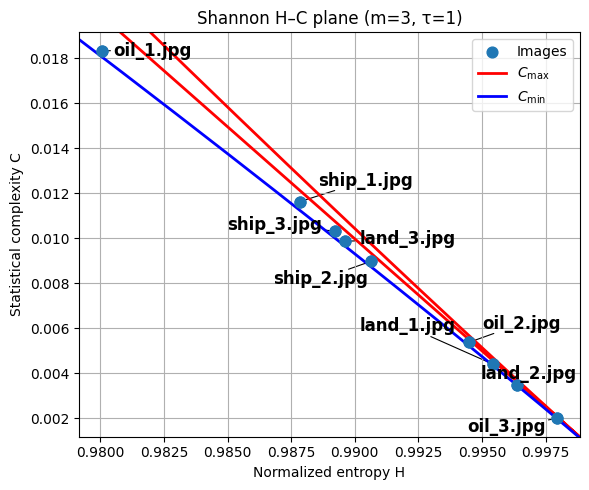

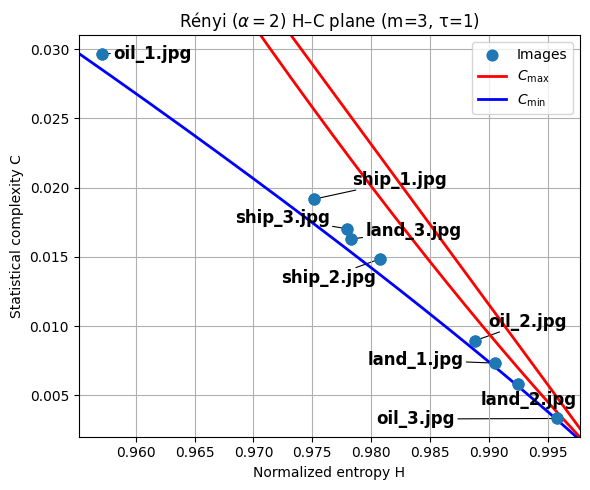

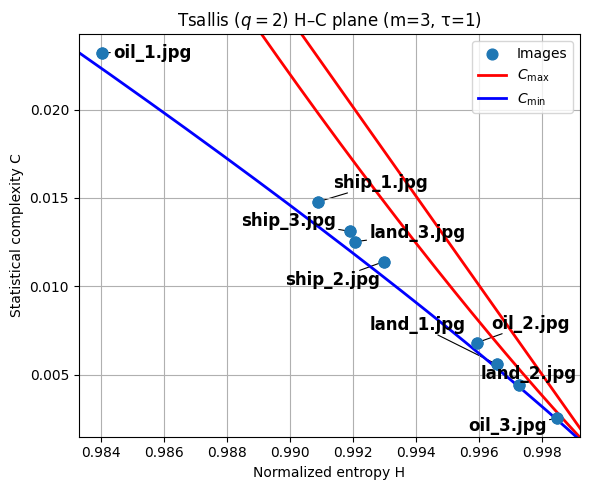

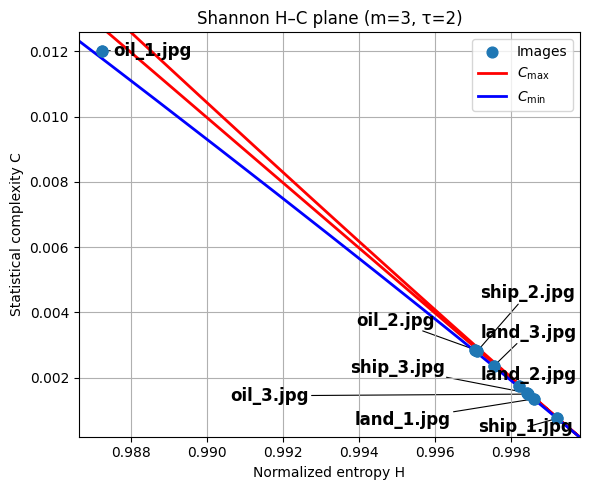

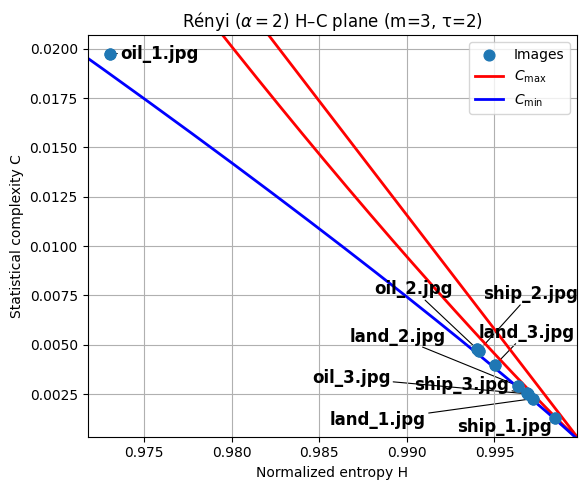

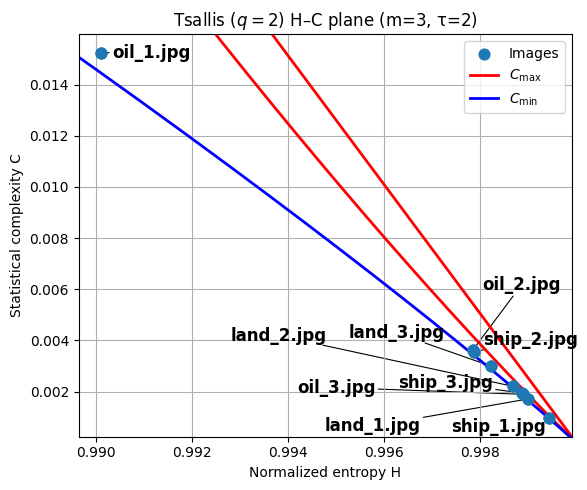

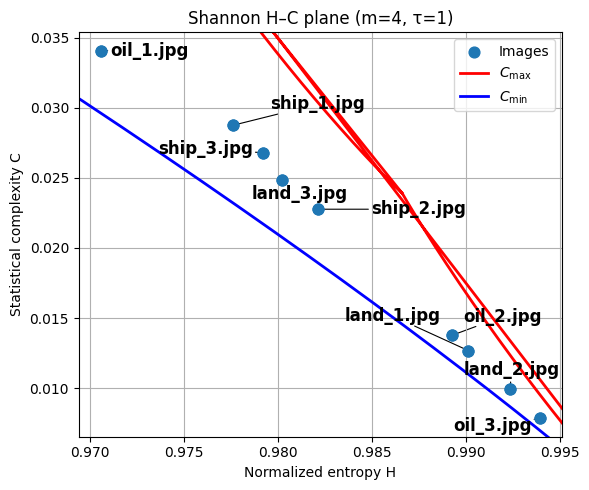

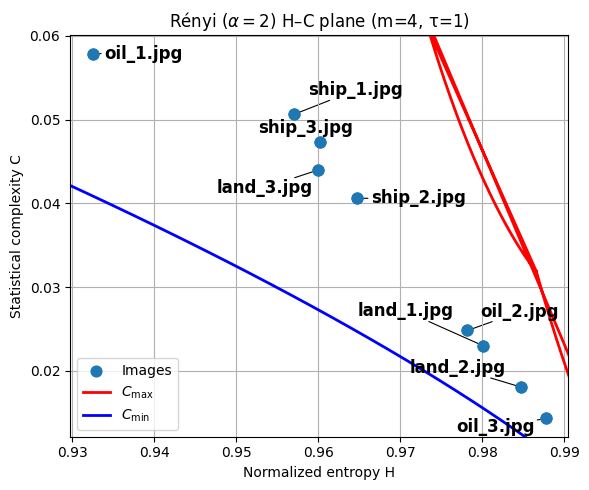

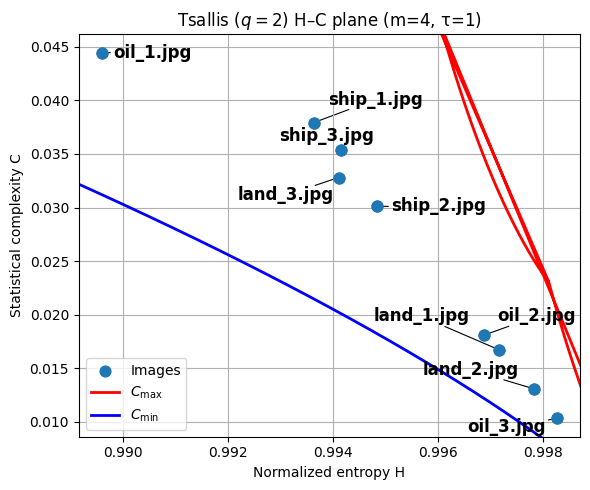

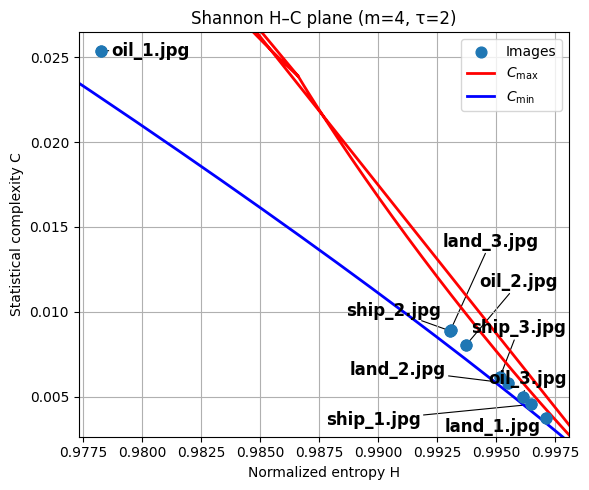

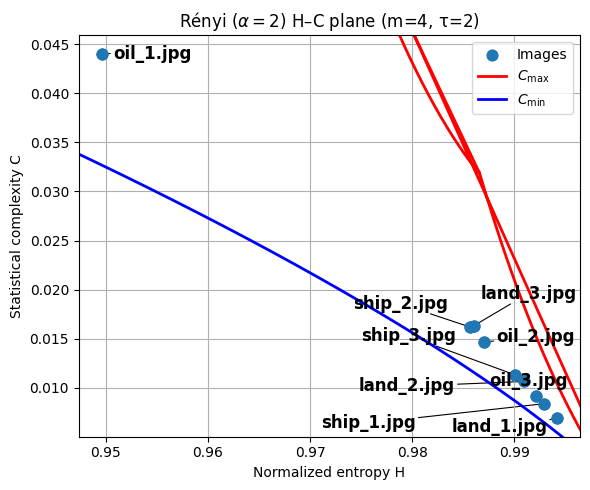

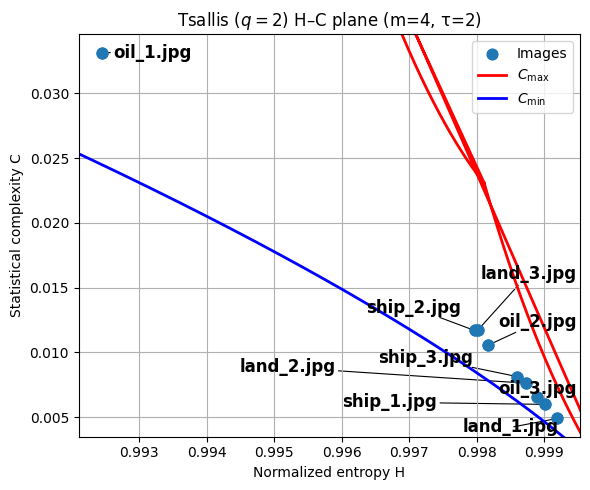

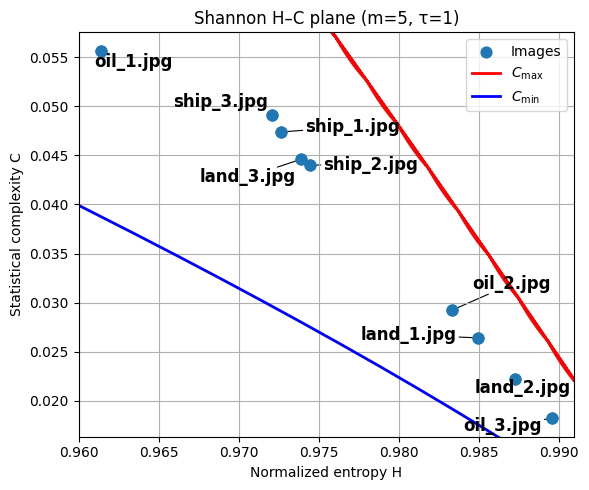

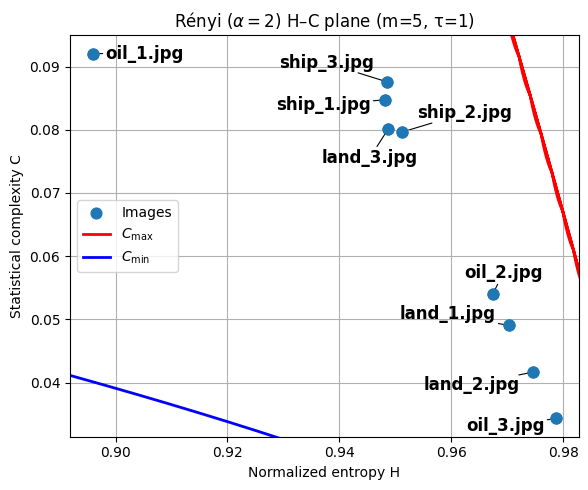

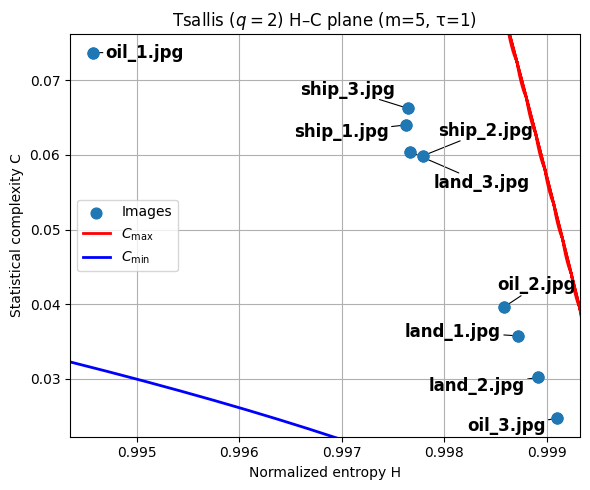

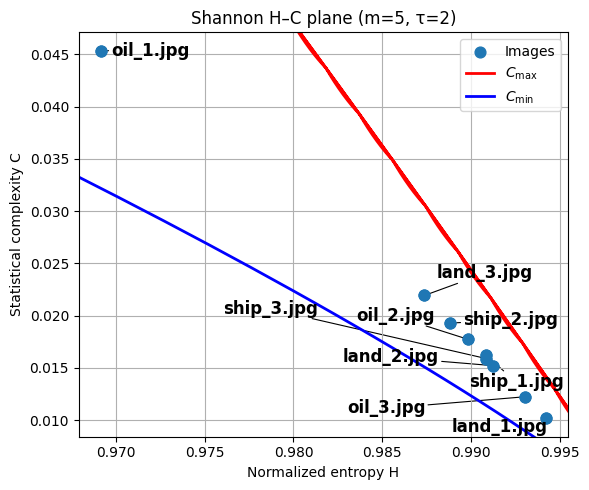

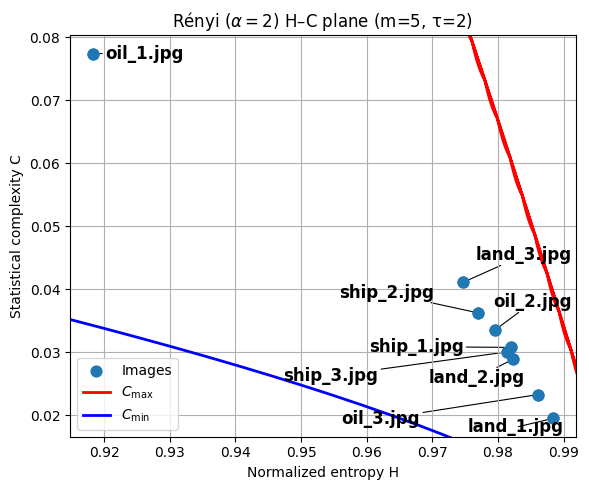

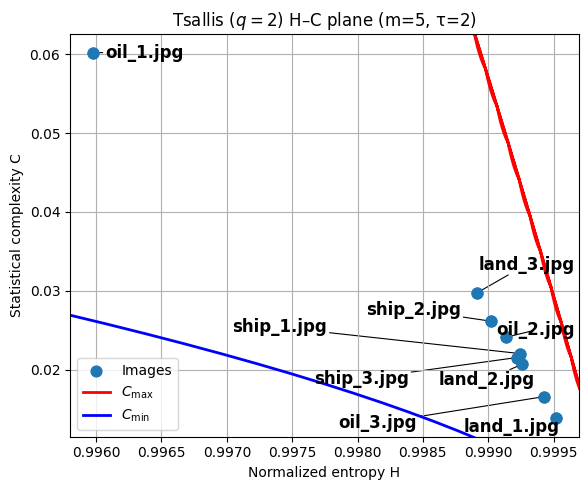

In [83]:
from itertools import product
importlib.reload(utils)
import math
for m, tau in product(m_values, tau_values):
    subset = entropy_complexity_df[
        (entropy_complexity_df.m == m) &
        (entropy_complexity_df.tau == tau)
    ]

    for spec in ENTROPY_SPECS.values():
        k = math.factorial(m)
        Hmin, Cmin = utils.Cmin_curve(k, spec['H_func'], spec['D_func'])
        Hmax, Cmax = utils.Cmax_curve(k, spec['H_func'], spec['D_func'])
        bounds = {
        "Hmin": Hmin,
        "Cmin": Cmin,
        "Hmax": Hmax,
        "Cmax": Cmax,
        }

        utils.plot_entropy_complexity_planes(
            subset_df=subset,
            m=m,
            tau=tau,
            spec=spec,
            bounds=bounds,
            labels=labels
        )
